In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

#Current Working Directory
import os
cwd = os.getcwd()

from pathlib import Path

def tabulate(x, y, f):
    """Return a table of f(x, y)."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

np.set_printoptions(threshold=np.nan)

### Plot f contours

In [4]:
def get_fcontour(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 16

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 8

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'
    
    eng = 10**log10eng[:len(f_for_plot)]
    rs_list = [3000*np.exp(-0.001*coarsen_factor*(i)) for i in np.arange(6400/coarsen_factor)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.axis([eng[0], 10**log10eng[-1], 5, 2e3])

    levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 3e-1, 1e0])
    if inj_type is 'decay':
        if channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
            else:
                levels = np.array([1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 4e-2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 1e-0])
            else:
                levels = np.array([1e-4, 1e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1, 2e-1, 7e-1])
        elif (channel is 'heat') or (channel is 'cont'):
            if inj_particle is 'elec':
                levels = np.array([1e-5, 1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 3e-1, 5e-1, 1, 2])
    elif inj_type is 'swave':
        if channel is 'H_ion':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])
        elif channel is 'He_ion':
            if inj_particle is 'phot':
                levels = np.array([5e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 2])
        elif channel is 'exc':
            if inj_particle is 'phot':
                levels = np.array([5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 1e2, 3e2])
        elif channel is 'heat':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1, 5, 1e1, 3e1])
        elif channel is 'cont':
            if inj_particle is 'phot':
                levels = np.array([1e-3, 1e-2, 2e-2, 5e-2, 1e-1, 5e-1, 1, 5, 1e1, 5e1, 1e2])

                
    f_for_plot[f_for_plot < levels[0]] = levels[0]*(1+.01)
    f_for_plot[f_for_plot > levels[-1]] = levels[-1]*(1-.01)
    
    levels2 = np.exp(np.linspace(np.log(levels[0]),np.log(levels[-1]),100))
    cs = ax.contourf(eng,rs_list,
                     np.transpose(f_for_plot[:,:,ind]), 
#                      locator=matplotlib.ticker.LogLocator(), 
                     norm=matplotlib.colors.LogNorm(),
                     levels=levels2,
                     cmap=matplotlib.cm.RdBu_r)
    ax.contour(eng,rs_list,
               np.transpose(f_for_plot[:,:,ind]),  
               levels=levels[1:-1],
               colors='k',
               alpha=.4
              )

    cbar = plt.colorbar(cs, ticks=levels)
    cbar.ax.set_xticklabels(str(levels))

    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

#     direc = '/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'
#     plt.savefig(
#         direc+'f'+inj_particle+'_'+inj_type+'_'+channel+'_contour.pdf'
#     )

In [234]:
np.log10(10**log10eng+phys.me)[[21,22,23,24,26,27,28,29,32,33,34,36,37,38,39]]

array([ 8.58259186,  8.81487611,  9.04726101,  9.27970431,  9.74467935,
        9.97718861, 10.20970474, 10.44222489, 11.13979596, 11.37232112,
       11.6048456 , 12.06989689, 12.30242263, 12.53494841, 12.60150605])

In [249]:
log10eng2 = np.concatenate([log10eng[:20], log10eng[[21,22,23,24,26,27,28,29,32,33,34,36,37,38,39]]])

In [250]:
direc = '/home/gridgway/Desktop/DH_Data/idl_comparison/'
inj_particle='electron'

float_formatter = lambda x,n: ("{:."+str(n)+"E}").format(x,n)

rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6398)]
f_idl_list = np.zeros((len(log10eng2),5,6398))
for i, eng in enumerate(log10eng2):
    print(eng)
    hdul = fits.open(
        direc+inj_particle+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_'
        +float_formatter(np.log10(10**eng+phys.me), 3)+'_xe_0.000E+00.fits'
    )

    data = hdul[1].data

    f_idl_low  = data.field('loweng_deposition_fractions')[0]
    f_idl_high = data.field('higheng_deposition_fractions')[0]
    idl_redshift     = data.field('redshift')[0]

    f_idl_list[i,:] = f_idl_low + f_idl_high


    hdul.close()

3.6989700794219966
3.9314956665039062
4.1640214920043945
4.396547317504883
4.629073143005371
4.8615989685058585
5.094124317169189
5.326650142669677
5.559175968170165
5.791701793670654
6.024227619171142
6.256753444671631
6.48927879333496
6.721804618835448
6.9543304443359375
7.186856269836425
7.419382095336913
7.651907920837402
7.8844332695007315
8.116959571838379
8.582011222839354
8.814536094665526
9.047061920166014
9.279587745666504
9.744639396667479
9.977165222167967
10.209691047668457
10.442216873168945
11.13979434967041
11.372320175170898
11.60484504699707
12.069896697998045
12.302422523498533
12.534948348999022
12.601505994846297


In [252]:
def get_fdiff(inj_type, inj_particle, channel):
    if inj_particle is 'elec':
        coarsen_factor = 1
        eng = 10**log10eng2

        if inj_type is 'decay':
            f_for_plot = f_decay_elec.copy()
            folder='elec_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_elec.copy()
            folder='elec_swave/'
    else:
        coarsen_factor = 1
        eng = 10**log10eng

        if inj_type is 'decay':
            f_for_plot = f_decay_phot.copy()
            folder='phot_decay/'

        elif inj_type is 'swave':
            f_for_plot = f_swave_phot.copy()
            folder='phot_swave/'
            
    tmp = np.concatenate([np.arange(20), np.array([21,22,23,24,26,27,28,29,32,33,34,36,37,38,39])])

    rs_list = [3000*np.exp(-0.001*i) for i in np.arange(6397)]

    if channel is 'H_ion':
        ind=0
        title = r'\bf{$f_{H ion}$}'
#         f_interp = f_H_ion
    elif channel is 'He_ion':
        ind=1
        title = r'\bf{$f_{He ion}$}'
#         f_interp = f_He_ion
    elif channel is 'exc':
        ind=2
        title = r'\bf{$f_{exc}$}'
#         f_interp = f_H_exc
    elif channel is 'heat':
        ind=3
        title = r'\bf{$f_{heat}$}'
#         f_interp = f_heating
    elif channel is 'cont':
        ind=4
        title = r'\bf{$f_{cont}$}'
#         f_interp = f_cont

    plt.figure()
    ax=plt.gca()
    ax.loglog()
    levels=[0,.01,.05,.1,.5]#,.2,.3,.4,.5,1]
    
    diffs = np.zeros_like(f_for_plot[tmp,:,ind])
#     tmp = tabulate(rs_list, eng, f_interp)

    diffs = np.abs(
        f_for_plot[tmp,:,ind] - f_idl_list[:,ind,:-1]
    )/f_idl_list[:,ind,:-1]
            
    cs2 = ax.contourf(eng, rs_list, np.transpose(diffs), levels = levels,
#                      norm=matplotlib.colors.LogNorm(),
                     cmap=matplotlib.cm.RdBu_r)
#     ax.contour(eng,rs_list[25:],
#                np.transpose(diffs)[25:],  
#                levels=levels[1:-1],
#                colors='k',
#                alpha=.4
#               )
    cbar = plt.colorbar(cs2, ticks=levels)
    
    plt.title(title)
    plt.ylabel(r'Redshift ($1+z$)')
    plt.xlabel(r'Kinetic Energy [eV]')

    plt.savefig(
        '/home/gridgway/Desktop/f_contour_debug/'+folder+'f'+inj_particle+'_'+inj_type+'_'+channel+'_IDLdiffs.pdf'
    )

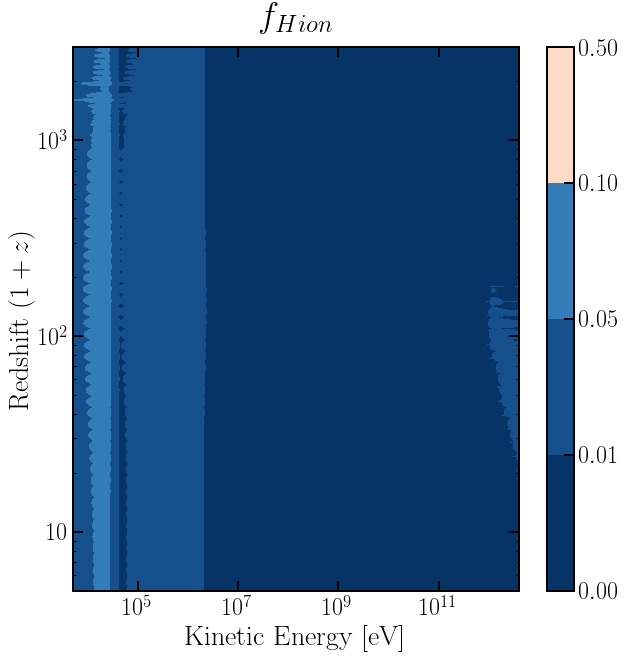

In [272]:
get_fdiff('decay','elec','H_ion')

In [266]:
f_decay_elec.shape

(40, 6397, 5)

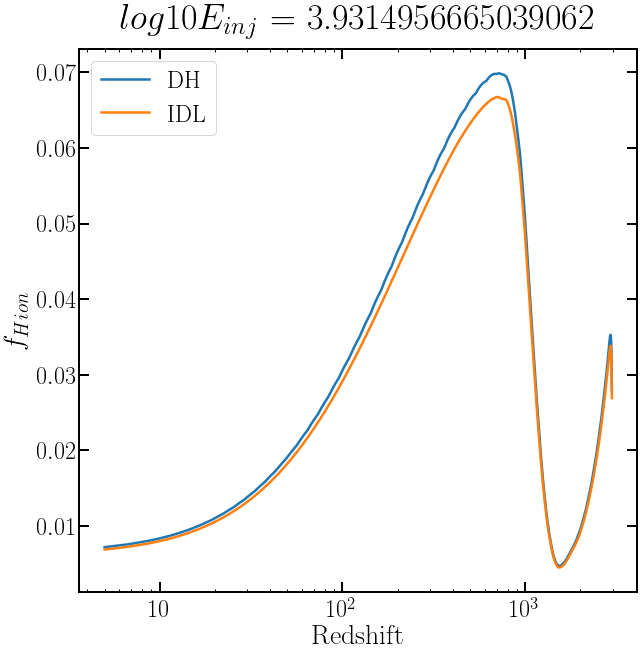

In [291]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

Eind=1
ind=0

plt.title('$log10E_{inj}$ = '+str(log10eng[Eind]))
plt.plot(rs_list[10:-1], f_decay_elec[Eind,10:,ind], label='DH')
plt.plot(rs_list[10:-1], f_idl_list[Eind,ind,10:-1], label='IDL')

# plt.plot(rs_list[10:-1], (f_decay_elec[Eind,10:,ind]-f_idl_list[Eind,ind,10:-1])/f_idl_list[Eind,ind,10:-1], label='DH')

plt.ylabel(r'$f_{Hion}$')
plt.xlabel(r'Redshift')

plt.legend()

plt.savefig('/home/gridgway/Desktop/fHion_discrepancy')

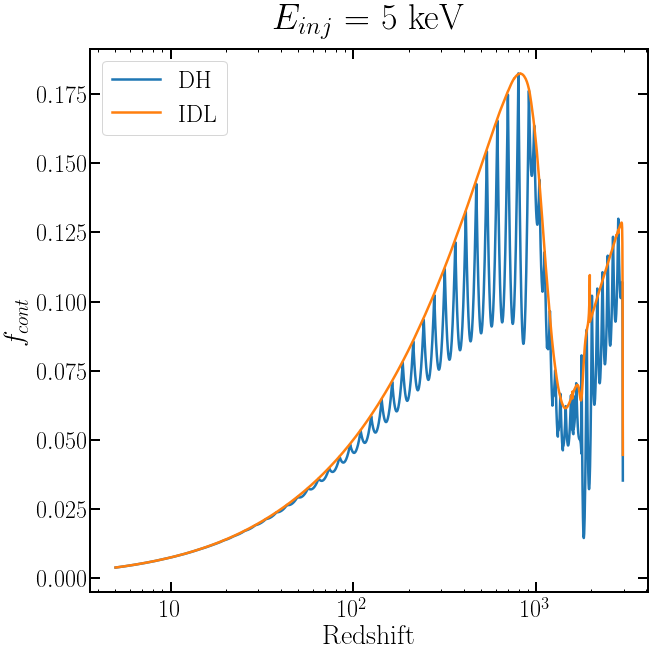

In [62]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')

plt.title('$E_{inj}$ = 5 keV')
plt.plot(rs_list[10:-1], f_decay_phot[0,10:,4], label='DH')
plt.plot(rs_list[10:-1], f_idl_list[0,4,10:-1], label='IDL')

plt.ylabel(r'$f_{cont}$')
plt.xlabel(r'Redshift')

plt.legend()
plt.savefig('/home/gridgway/Desktop/fcont_discrepancy')

In [46]:
(10**log10eng-phys.me)/10**log10eng

array([-101.19977155,  -58.83073499,  -34.02664272,  -19.5056097 ,
        -11.00457699,   -6.02782658,   -3.11429746,   -1.40862873,
         -0.41008092,    0.17449785,    0.51672716,    0.7170781 ,
          0.83436916,    0.90303491,    0.94323383,    0.96676744,
          0.9805447 ,    0.98861031,    0.99333214,    0.99609644,
          0.99771475,    0.99866215,    0.99921678,    0.99954148,
          0.99973157,    0.99984285,    0.999908  ,    0.99994614,
          0.99996847,    0.99998154,    0.99998919,    0.99999367,
          0.9999963 ,    0.99999783,    0.99999873,    0.99999926,
          0.99999956,    0.99999975,    0.99999985,    0.99999987])

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


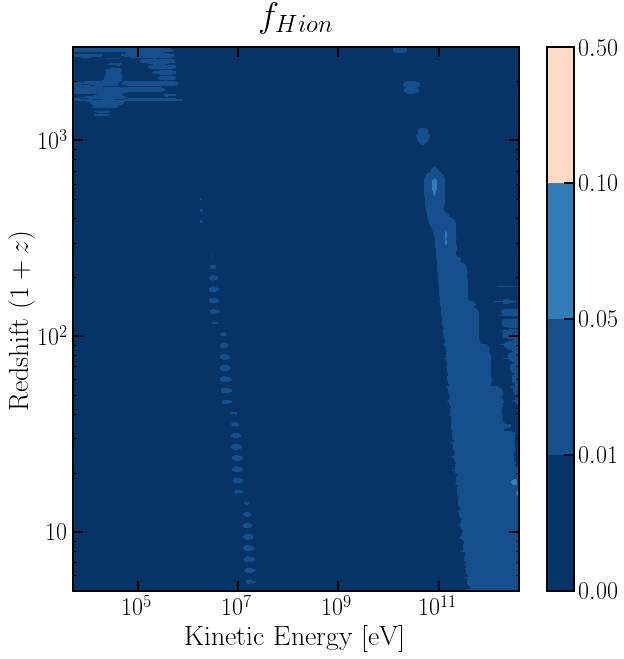

In [43]:
get_fdiff('decay','photon','H_ion')

(40, 800)
(40, 800, 5)


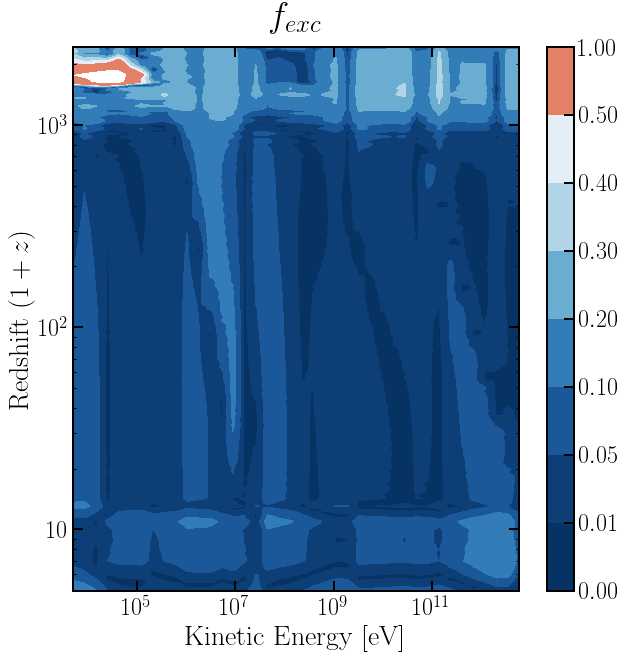

In [73]:
get_fdiff('decay','photon','exc')

In [122]:
log10eng[20:]

array([ 8.3494854 ,  8.58201122,  8.81453609,  9.04706192,  9.27958775,
        9.51211357,  9.7446394 ,  9.97716522, 10.20969105, 10.44221687,
       10.6747427 , 10.90726852, 11.13979435, 11.37232018, 11.60484505,
       11.83737087, 12.0698967 , 12.30242252, 12.53494835, 12.60150599])

In [124]:
np.log10(10**log10eng[20:]+phys.me)

array([ 8.35047674,  8.58259186,  8.81487611,  9.04726101,  9.27970431,
        9.51218181,  9.74467935,  9.97718861, 10.20970474, 10.44222489,
       10.67474739, 10.90727127, 11.13979596, 11.37232112, 11.6048456 ,
       11.8373712 , 12.06989689, 12.30242263, 12.53494841, 12.60150605])

### Download 2016 f(z)'s

In [7]:
direc = '/Users/GregoryRidgway/Downloads/'
direc = '/home/gridgway/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

In [8]:
user = '/Users/GregoryRidgway/Downloads/'
user = '/home/gridgway/Dropbox (MIT)/'
greg = ''

#---------- Decay ----------#
fz_elec_decay = np.loadtxt(user+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(user+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}


#---------- s-wave ----------#
fz_elec_swave = np.loadtxt(user+'21cm_pwave/TLA_code/fz_electron_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_elec_swave[0:70, 1]
log10eng = fz_elec_swave[0:2800:70, 0] 

log10f_elec_swave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_swave[11200:14000,2], (40,70))) 
}

fz_phot_swave = np.loadtxt(user+'21cm_pwave/TLA_code/fz_photon_swave_NFW_no_subs.dat', delimiter=',')

log10rs  = fz_phot_swave[0:70, 1]
log10eng = fz_phot_swave[0:2800:70, 0] 

log10f_phot_swave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_swave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_swave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_swave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_swave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_swave[11200:14000,2], (40,70)))
}

#---------- p-wave ----------#
fz_elec_pwave = np.loadtxt(user+'21cm_pwave/TLA_code/fz_electron_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_elec_pwave[0:70, 1]
log10eng = fz_elec_pwave[0:2800:70, 0] 

log10f_elec_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_elec_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_pwave[11200:14000,2], (40,70))) 
}

fz_phot_pwave = np.loadtxt(user+'21cm_pwave/TLA_code/fz_photon_pwave_NFW_no_subs'+
                           greg+'.dat', delimiter=',')

log10rs  = fz_phot_pwave[0:70, 1]
log10eng = fz_phot_pwave[0:2800:70, 0] 

log10f_phot_pwave = {
    'H_ion':   np.transpose(np.reshape(fz_phot_pwave[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_pwave[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_pwave[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_pwave[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_pwave[11200:14000,2], (40,70)))
}


In [9]:
log10f_tmp = log10f_phot_decay

def f_H_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_He_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['He_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_H_exc(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_exc'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_heating(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['heating'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_cont(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['cont'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

### Download Photon Transfer Functions

In [13]:
%autoreload
# direc = '/home/gridgway/Downloads/complete/'
# extra=""
direc = '/home/gridgway/Desktop/DH_Data/'
# extra = "_complete" 

direc_arr = [direc+'tfs_xHe0/', direc]
xes = np.array([
    0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]),
    None]
)
# string_arr = ["_post1700_xHe0", "_standard_xe_xHe_full_rs"]
string_arr = ["_xHe0", "_standard_xe_xHe_full_rs"]


# tf_file = Path(direc+"highengphot_tf_interp"+extra+".p")

# if tf_file.is_file() and False:
#     highengphot_tf_interp = pickle.load(open(direc+"highengphot_tf_interp"+extra+".p", "rb"))
#     lowengphot_tf_interp  = pickle.load(open(direc+"lowengphot_tf_interp"+extra+".p", "rb"))
#     lowengelec_tf_interp  = pickle.load(open(direc+"lowengelec_tf_interp"+extra+".p", "rb"))
#     highengdep_interp     = pickle.load(open(direc+"highengdep_interp"+extra+".p", "rb"))
#     CMB_engloss_interp    = pickle.load(open(direc+"CMB_engloss_interp"+extra+".p", "rb"))
# else:

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc_arr, xes, string_arr=string_arr, inverted=False)
    
#     pickle.dump(highengphot_tf_interp, open("/home/gridgway/Desktop/DH_Data/highengphot_tf_interp.p", "wb"))
#     pickle.dump(lowengphot_tf_interp, open("/home/gridgway/Desktop/DH_Data/lowengphot_tf_interp.p", "wb"))
#     pickle.dump(lowengelec_tf_interp, open("/home/gridgway/Desktop/DH_Data/lowengelec_tf_interp.p", "wb"))
#     pickle.dump(highengdep_interp, open("/home/gridgway/Desktop/DH_Data/highengdep_interp.p", "wb"))
#     pickle.dump(CMB_engloss_interp, open("/home/gridgway/Desktop/DH_Data/CMB_engloss_interp.p", "wb"))

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
noninterp
noninterp
Done.



In [15]:
highengphot_tf_interp.rs_nodes[0] = 1600
lowengphot_tf_interp.rs_nodes[0]  = 1600
lowengelec_tf_interp.rs_nodes[0]  = 1600
highengdep_interp.rs_nodes[0]     = 1600
CMB_engloss_interp.rs_nodes[0]    = 1600

In [18]:
ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()

********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

In [19]:
direc = '/Users/GregoryRidgway/Downloads/'
direc = '/home/gridgway/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0]

log10eng[-1] = np.log10(highengphot_tf_interp.eng[-1])*(.99)

struct_data = np.loadtxt(open(cwd+"/../structure_formation_data/boost_Einasto_subs.txt", "rb"))
log_struct_interp = interp1d(np.log(struct_data[:,0]), np.log(struct_data[:,1]))
def struct_boost(rs):
    if rs<76:
        return np.exp(log_struct_interp(np.log(rs)))
    else:
        return 1

def rate_func_decay_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/Ecom
def rate_func_decay_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau) 

def rate_func_swave_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
def rate_func_swave_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs) 

photeng = highengphot_tf_interp.eng
eleceng = lowengelec_tf_interp.eng

# Decay to Photons

### decay, photons

In [127]:
direc = '/home/gridgway/Desktop/DH_Data/'

hdul = fits.open(
    direc
    +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_6622_logE_7.301E+00_xe_0.000E+00.fits'
)

    
data = hdul[1].data

idl_redshift = data.field('redshift')[0]
xe_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

In [21]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-26#1e-26
f_decay_phot = []
for i,Einj in enumerate(tqdm(10**log10eng)):
    mDM = 2*Einj
    Ecom = mDM
    tau = 1e25
    
    indTmp = spectools.get_indx(photeng,Einj)
    if indTmp == len(photeng) or photeng[indTmp] >= Einj:
        indTmp -= 1

    phot_spec_init = spectools.rebin_N_arr(
        np.array([mDM/photeng[indTmp]]),
        np.array([photeng[indTmp]]),
        photeng
    )
    
    elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000, spec_type = 'N')
    
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
#         ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        struct_boost=None,
        ics_only=False, separate_higheng=False,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )
    
    f_decay_phot.append(data_phot[6])

rs_list_phot = data_phot[3].rs
f_decay_phot = np.array(f_decay_phot)

pickle.dump(f_decay_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [141]:
10**log10eng[1]

8540.74325214437

# Decay to Electrons

Download ICS transfer functions

In [10]:
ics_file = Path("/home/gridgway/Desktop/DH_Data/ics_thomson_ref_tf.p")

if ics_file.is_file():
    ics_thomson_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/ics_thomson_ref_tf.p", "rb"))
    ics_rel_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/ics_rel_ref_tf.p", "rb"))
    engloss_ref_tf = pickle.load(open("/home/gridgway/Desktop/DH_Data/engloss_ref_tf.p", "rb"))
else:
    ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()
    pickle.dump(ics_thomson_ref_tf, open("/home/gridgway/Desktop/DH_Data/ics_thomson_ref_tf.p", "wb"))
    pickle.dump(ics_rel_ref_tf, open("/home/gridgway/Desktop/DH_Data/ics_rel_ref_tf.p", "wb"))
    pickle.dump(engloss_ref_tf, open("/home/gridgway/Desktop/DH_Data/engloss_ref_tf.p", "wb"))

In [159]:
f_decay_elec = np.array(f_decay_elec)

In [93]:
f_idl_list[0,0,0::16]

array([2.14063809e-05, 3.19922839e-02, 3.36544329e-02, 3.21870621e-02,
       3.05203630e-02, 2.89069359e-02, 2.73709004e-02, 2.59119919e-02,
       2.45267232e-02, 2.32113777e-02, 2.19621149e-02, 2.07752149e-02,
       1.96477595e-02, 1.85770475e-02, 1.75608612e-02, 1.65974794e-02,
       1.56839879e-02, 1.48184347e-02, 1.39990099e-02, 1.32240296e-02,
       1.24915007e-02, 1.17996338e-02, 1.11468319e-02, 1.05315851e-02,
       9.95242087e-03, 9.40764575e-03, 8.89587442e-03, 8.44018145e-03,
       8.04648114e-03, 7.68457154e-03, 7.34868702e-03, 7.02927351e-03,
       6.71445312e-03, 6.39589011e-03, 6.07720117e-03, 5.77080733e-03,
       5.48462399e-03, 5.22110183e-03, 4.98367428e-03, 4.78149642e-03,
       4.65076227e-03, 4.56375732e-03, 4.50946908e-03, 4.57949868e-03,
       4.78149382e-03, 5.10298396e-03, 5.54723941e-03, 6.13988266e-03,
       6.90661132e-03, 7.76240783e-03, 8.77108368e-03, 9.85049353e-03,
       1.11028258e-02, 1.25536107e-02, 1.41045771e-02, 1.57410098e-02,
      

In [87]:
f_decay_elec[0,:,0]

array([2.33104999e-05, 3.44045398e-02, 3.62978629e-02, 3.47968785e-02,
       3.29613204e-02, 3.10504282e-02, 2.95294842e-02, 2.80514113e-02,
       2.65389696e-02, 2.49894004e-02, 2.37050274e-02, 2.25116802e-02,
       2.12913438e-02, 2.00411405e-02, 1.89606380e-02, 1.80005991e-02,
       1.70206269e-02, 1.60171666e-02, 1.51155770e-02, 1.43511171e-02,
       1.35720513e-02, 1.27744235e-02, 1.20297448e-02, 1.14293899e-02,
       1.08187826e-02, 1.01937652e-02, 9.59212958e-03, 9.16006752e-03,
       8.72386789e-03, 8.27940374e-03, 7.83178720e-03, 7.51007291e-03,
       7.18635106e-03, 6.85658563e-03, 6.52088938e-03, 6.23160768e-03,
       5.94363432e-03, 5.64872927e-03, 5.34836399e-03, 5.15205144e-03,
       5.02630193e-03, 4.85562017e-03, 4.72978705e-03, 4.73558337e-03,
       4.88149169e-03, 5.12199532e-03, 5.48038296e-03, 6.01186427e-03,
       6.73762105e-03, 7.54723066e-03, 8.52404027e-03, 9.56250458e-03,
       1.08472381e-02, 1.23225787e-02, 1.38945136e-02, 1.55715244e-02,
      

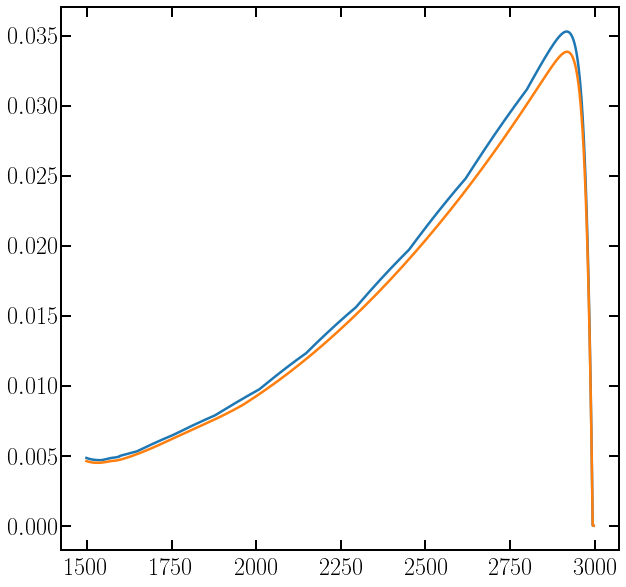

In [146]:
plt.figure()
ax = plt.gca()

plt.plot(
    data_elec[3].rs[1:], 
    f_decay_elec[0,:,0]
)
plt.plot(
    data_elec[3].rs[1:], 
    f_idl_list[0,0,0:len(data_elec[3].rs[1:])]
)

In [149]:
data_elec[0]

array([[1.00000000e+00, 9.98875841e-01],
       [9.99999997e-01, 9.98837687e-01],
       [9.99999997e-01, 9.98798191e-01],
       [9.99999997e-01, 9.98757313e-01],
       [9.99999997e-01, 9.98715007e-01],
       [9.99999997e-01, 9.98671221e-01],
       [9.99999997e-01, 9.98625886e-01],
       [9.99999997e-01, 9.98578964e-01],
       [9.99999997e-01, 9.98530386e-01],
       [9.99999997e-01, 9.98480103e-01],
       [9.99999997e-01, 9.98428035e-01],
       [9.99999997e-01, 9.98374142e-01],
       [9.99999997e-01, 9.98318341e-01],
       [9.99999997e-01, 9.98260566e-01],
       [9.99999996e-01, 9.98200746e-01],
       [9.99999996e-01, 9.98138812e-01],
       [9.99999996e-01, 9.98074673e-01],
       [9.99999996e-01, 9.98008268e-01],
       [9.99999996e-01, 9.97939504e-01],
       [9.99999996e-01, 9.97868284e-01],
       [9.99999996e-01, 9.97794539e-01],
       [9.99999996e-01, 9.97718167e-01],
       [9.99999996e-01, 9.97639071e-01],
       [9.99999996e-01, 9.97557161e-01],
       [9.999999

In [157]:
10**log10eng

array([5.00000086e+03, 8.54074325e+03, 1.45888645e+04, 2.49199587e+04,
       4.25670098e+04, 7.27108076e+04, 1.24200778e+05, 2.12153472e+05,
       3.62389802e+05, 6.19015885e+05, 1.05737155e+06, 1.80614846e+06,
       3.08516782e+06, 5.26992724e+06, 9.00182248e+06, 1.53764567e+07,
       2.62652837e+07, 4.48650257e+07, 7.66360778e+07, 1.30906006e+08,
       2.23607001e+08, 3.81954141e+08, 6.52433263e+08, 1.11445342e+09,
       1.90365282e+09, 3.25172321e+09, 5.55442871e+09, 9.48779346e+09,
       1.62065677e+10, 2.76832372e+10, 4.72871020e+10, 8.07734298e+10,
       1.37973077e+11, 2.35678614e+11, 4.02573374e+11, 6.87655423e+11,
       1.17461813e+12, 2.00642312e+12, 3.42727023e+12, 3.99490076e+12])

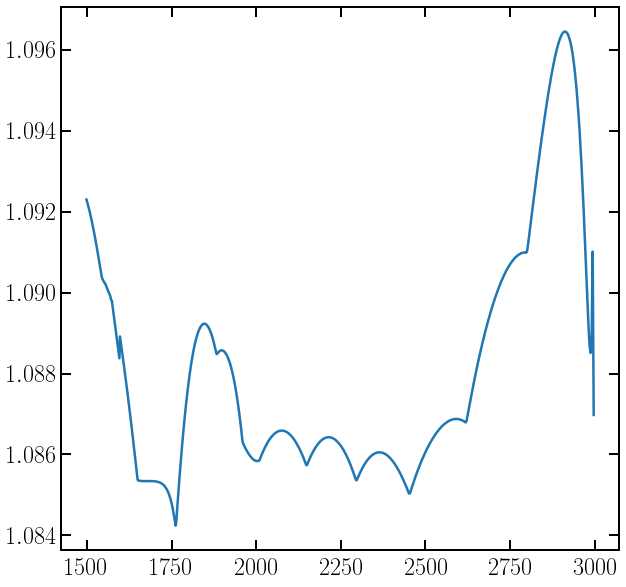

In [160]:
plt.figure()
ax = plt.gca()

plt.plot(
    data_elec[3].rs[1:], 
    np.abs((f_decay_elec[0,:,1]-f_idl_list[0,1,0:len(data_elec[3].rs[1:])])/f_idl_list[0,1,0:len(data_elec[3].rs[1:])]))

In [181]:
f_idl_low

array([[ 9.90593981e-08,  2.15402153e-01,  2.16322938e-01,
         2.17116962e-01,  2.17801235e-01,  2.18390744e-01,
         2.18897856e-01,  2.19334542e-01,  2.19709891e-01,
         2.20032473e-01,  2.20309969e-01,  2.20548090e-01,
         2.20752108e-01,  2.20927192e-01,  2.21077022e-01,
         2.21205558e-01,  2.21315805e-01,  2.21409998e-01,
         2.21491036e-01,  2.21560414e-01,  2.21619440e-01,
         2.21670165e-01,  2.21713198e-01,  2.21749994e-01,
         2.21781561e-01,  2.21808301e-01,  2.21831867e-01,
         2.21851988e-01,  2.21868927e-01,  2.21883446e-01,
         2.21895789e-01,  2.21906138e-01,  2.21915294e-01,
         2.21923048e-01,  2.21929974e-01,  2.21936286e-01,
         2.21941413e-01,  2.21945829e-01,  2.21949728e-01,
         2.21952829e-01,  2.21955826e-01,  2.21958470e-01,
         2.21960807e-01,  2.21963402e-01,  2.21965596e-01,
         2.21967449e-01,  2.21969176e-01,  2.21970616e-01,
         2.21971975e-01,  2.21973320e-01,  2.21974550e-0

In [ ]:
f_decay_elec[0,0,:,0]

In [184]:
f_idl_low.shape

(5, 184)

In [183]:
f_decay_elec[0,0,:,0]-f_idl_low[0,0,0:len(data_elec[3].rs[1:])]

IndexError: too many indices for array

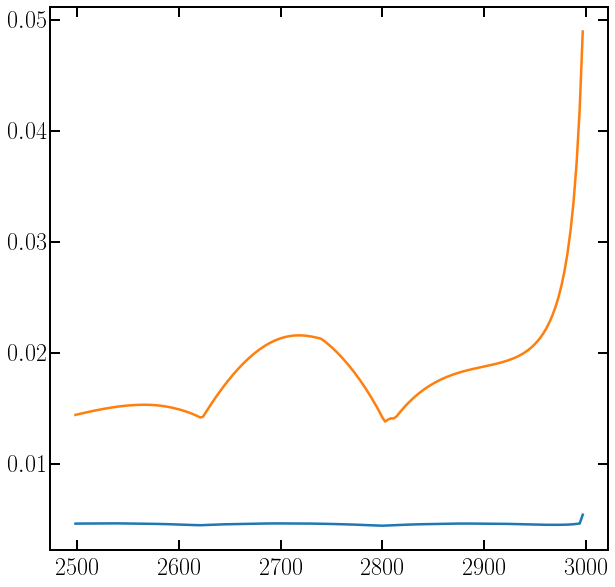

In [191]:
plt.figure()
ax = plt.gca()

plt.plot(
    data_elec[3].rs[1:], 
    (f_decay_elec[0,0,:,0]-f_idl_low[0,0:len(data_elec[3].rs[1:])])/f_idl_low[0,0:len(data_elec[3].rs[1:])]
)

plt.plot(
    data_elec[3].rs[1:], 
    (f_decay_elec[0,1,:,0]-f_idl_high[0,0:len(data_elec[3].rs[1:])])/f_idl_high[0,0:len(data_elec[3].rs[1:])])

In [174]:
hdul = fits.open(
#     direc+'/calcfracs_tf_z_3.000E+03_nstep_6398_logE_6.301_xe_0.000E+00.fits'
    direc+'/calcfracs.fits'
)

data = hdul[1].data

f_idl_low  = data.field('loweng_deposition_fractions')[0]
f_idl_high = data.field('higheng_deposition_fractions')[0]
idl_redshift     = data.field('redshift')[0]

# f_idl_list[i,:] = f_idl_low + f_idl_high


hdul.close()

In [170]:
np.abs(f_idl_low[0,:694]/f_decay_elec[0,0,:,0]-1)

array([0.04167603, 0.04541735, 0.03375547, 0.03406877, 0.03439924,
       0.03473459, 0.03509313, 0.03542808, 0.0357767 , 0.03611489,
       0.03642753, 0.03674773, 0.03707944, 0.03740149, 0.03773311,
       0.03804667, 0.03834522, 0.0386431 , 0.03889981, 0.03915003,
       0.03941087, 0.0396485 , 0.03989342, 0.0401229 , 0.04033254,
       0.04054461, 0.04069513, 0.04083769, 0.04098516, 0.04112105,
       0.04124612, 0.04137267, 0.04146414, 0.04155184, 0.04160483,
       0.04162257, 0.04164706, 0.04166256, 0.04166183, 0.04166783,
       0.04163836, 0.04159642, 0.04153603, 0.04142916, 0.04131863,
       0.04120639, 0.04107527, 0.04094254, 0.04079187, 0.04061669,
       0.04043635, 0.04019557, 0.03994196, 0.03969578, 0.03942682,
       0.03915201, 0.03886866, 0.03854785, 0.03822603, 0.03785533,
       0.03745423, 0.03705328, 0.03664235, 0.03621185, 0.03577905,
       0.03531017, 0.03482664, 0.03431294, 0.03375698, 0.03401333,
       0.03448399, 0.03493407, 0.03539001, 0.03582222, 0.03623

In [171]:
np.abs(f_idl_high[0,:694]/f_decay_elec[0,1,:,0]-1)

array([0.08437898, 0.0671447 , 0.06079128, 0.05753367, 0.05558178,
       0.05430206, 0.05341281, 0.05277095, 0.05229442, 0.05193395,
       0.0516581 , 0.05144474, 0.05127945, 0.05115099, 0.05105162,
       0.05097585, 0.05091797, 0.05087511, 0.05084406, 0.05082224,
       0.05080791, 0.05079974, 0.05079566, 0.05079499, 0.05079647,
       0.05079881, 0.0508021 , 0.05080457, 0.05080653, 0.05080695,
       0.05080514, 0.0508008 , 0.05079328, 0.05078201, 0.05076742,
       0.05074801, 0.05072389, 0.05069404, 0.05065825, 0.05061663,
       0.05056839, 0.05051249, 0.0504492 , 0.05037778, 0.05029766,
       0.05020892, 0.05011034, 0.05000223, 0.04988365, 0.04975361,
       0.04961276, 0.04945994, 0.0492942 , 0.04911598, 0.04892361,
       0.04871744, 0.04849627, 0.04825969, 0.0480072 , 0.04773591,
       0.0474469 , 0.04714   , 0.04681416, 0.04646923, 0.04627681,
       0.04628582, 0.04616828, 0.0459716 , 0.04637986, 0.04691545,
       0.04741997, 0.04790024, 0.04835965, 0.0488005 , 0.04922

In [192]:
%autoreload
inj_type='decay'
end_rs = 5
sigmav = 3e-27#1e-26
f_decay_elec = []
for i,Einj in enumerate(tqdm(10**log10eng)):
    mDM = 2*Einj + 2*phys.me
    Ecom=mDM
    tau=.5e25
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    
    indTmp = spectools.get_indx(eleceng,Einj)
    if eleceng[indTmp] >= Einj:
        indTmp -= 1
    
    elec_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/eleceng[indTmp]]),
        np.array([eleceng[indTmp]]),
        eleceng
    )

    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_decay_N, rate_func_decay_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=False,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )
    
    f_decay_elec.append(data_elec[6])

rs_list_elec = data_elec[3].rs
f_decay_elec = np.array(f_decay_elec)

pickle.dump(f_decay_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "wb"))

../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)


/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


### swave, photons

In [87]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26

Einj = 10**log10eng[-8]
mDM = Einj
Ecom=2*mDM

indTmp = spectools.get_indx(photeng,Einj)
if photeng[indTmp] >= Einj:
    indTmp -= 1

phot_spec_init = spectools.rebin_N_arr(
    np.array([mDM/photeng[indTmp]]),
    np.array([photeng[indTmp]]),
    photeng
)

elec_spec_init = Spectrum(eng=eleceng, data=np.zeros_like(eleceng), rs=3000, spec_type='N')

phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

data_phot = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_swave_N, rate_func_swave_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
#         ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=8, std_soln=True,
    struct_boost=struct_boost,
    ics_only=False, separate_higheng=False,
    xe_func=xe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

AHHHH YEAHHHH!
completed rs:  3000
completed rs:  2988.0239680319733
completed rs:  2976.095744511182
completed rs:  2964.2151385857933
completed rs:  2952.3819601658583
completed rs:  2940.59601992027
completed rs:  2928.8571292737333
completed rs:  2917.165100403747
completed rs:  2905.5197462376004
completed rs:  2893.9208804493783
completed rs:  2882.36831745698
completed rs:  2870.8618724191515
completed rs:  2859.401361232527
completed rs:  2847.9866005286826
completed rs:  2836.617407671204
completed rs:  2825.2936007527624
completed rs:  2814.014998592206
completed rs:  2802.781420731659
completed rs:  2791.592687433637
completed rs:  2780.4486196781677
completed rs:  2769.3490391599294
completed rs:  2758.293768285397
completed rs:  2747.282630170001
completed rs:  2736.315448635297
completed rs:  2725.392048206145
completed rs:  2714.5122541079063
completed rs:  2703.675892263643
completed rs:  2692.8827892913346
completed rs:  2682.132772501103
completed rs:  2671.4256698924

completed rs:  1130.446049228883
completed rs:  1125.9332965543192
completed rs:  1121.43855883652
completed rs:  1116.9617641595864
completed rs:  1112.5028408947076
completed rs:  1108.0617176990168
completed rs:  1103.6383235144476
completed rs:  1099.232587566599
completed rs:  1094.8444393636019
completed rs:  1090.473808694991
completed rs:  1086.120625630583
completed rs:  1081.7848205193554
completed rs:  1077.4663239883346
completed rs:  1073.1650669414832
completed rs:  1068.8809805585972
completed rs:  1064.613996294203
completed rs:  1060.364045876461
completed rs:  1056.1310613060743
completed rs:  1051.9149748551993
completed rs:  1047.715719066363
completed rs:  1043.533226751383
completed rs:  1039.3674309902929
completed rs:  1035.218265130272
completed rs:  1031.0856627845776
completed rs:  1026.9695578314843
completed rs:  1022.8698844132251
completed rs:  1018.7865769349378
completed rs:  1014.7195700636155
completed rs:  1010.6687987270616
completed rs:  1006.63419

In [58]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e25
f_swave_phot = []
for i,Einj in enumerate(tqdm(10**log10eng)):
    mDM = Einj
    Ecom=2*mDM
    
    indTmp = spectools.get_indx(photeng,Einj)
    if photeng[indTmp] >= Einj:
        indTmp -= 1
    
    phot_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/photeng[indTmp]]),
        np.array([photeng[indTmp]]),
        photeng
    )
#     phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       highengphot_tf_interp.eng)
    phot_spec_init.rs = 3000
    phot_spec_init.switch_spec_type()
    elec_spec_init = Spectrum(eleceng, 0*eleceng, rs=3e3)
    elec_spec_init.switch_spec_type()

    data_phot = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
#         ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=8, std_soln=True,
        struct_boost=struct_boost,
        ics_only=False, separate_higheng=False,
        xe_func=xe_idl_func, user=None, verbose=False, 
        use_tqdm=True
    )
    
    f_swave_phot.append(data_phot[6])

rs_list_phot = data_phot[3].rs
f_swave_phot = np.array(f_swave_phot)

pickle.dump(f_swave_phot, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot_v2.p", "wb"))

IndexError: index 500 is out of bounds for axis 0 with size 500

In [18]:
direc='/Users/GregoryRidgway/Desktop/Dark Matter/DH_Data/'
f_swave_phot = np.array(f_swave_phot)
pickle.dump(f_swave_phot, open(direc+"f_swave_phot.p", "wb"))

# IDL vs. interpolated DH vs. Mathematica

In the below residual plot, white regions are greater than 10% errors and need to be understood.  First we start with continuum.

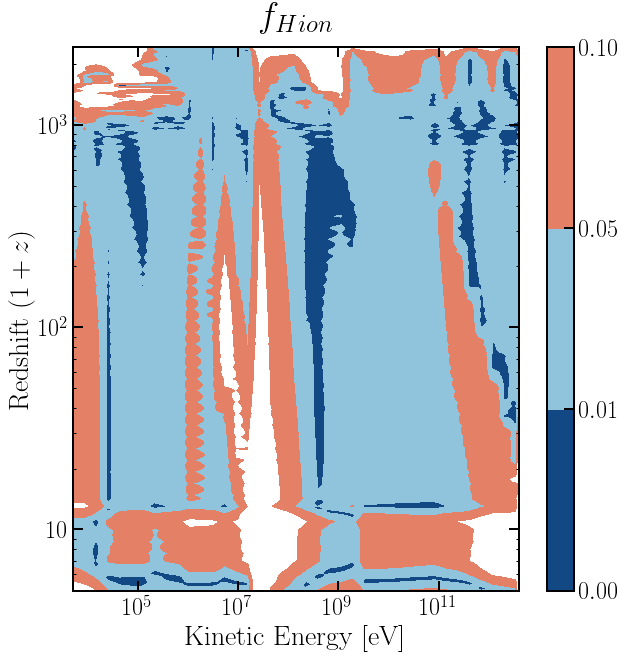

In [185]:
get_fdiff('decay','photon','H_ion')

Now download the Mathematica f's and the interpolated DH f's

In [321]:
Einj = 2e7

log10f_tmp = log10f_phot_decay

name_arr = ['H_ion', 'He_ion', 'H_exc', 'heating', 'cont']

def f_mathematica(rs, Einj, ind):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp[name_arr[ind]])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

In [423]:
string="_v3"
# string=""
f_decay_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot"+string+".p", "rb"));

In [323]:
from scipy.interpolate import RegularGridInterpolator

tmp = np.transpose(np.array([np.log10(Einj)*np.ones_like(rs_list), np.log10(rs_list)]));

rs_list = [3000*np.exp(-0.001*8*i) for i in np.arange(6400/8)]

f_decay_phot[f_decay_phot<=0] = 1e-200

log10f_DH = RegularGridInterpolator(
                (log10eng, np.log10(np.flipud(rs_list))), np.log10(np.flip(f_decay_phot, axis=1))
            )

DH_fs = 10**log10f_DH(tmp)

Download IDL file f's

In [396]:
direc = '/home/gridgway/Desktop/DH_Data/'

if Einj == 2e7:
    hdul = fits.open(
                direc
                +'calculated_fractions_logE_7.301E+00_standard_xe_xHe.fits'
            )
elif Einj == 2e5:
    hdul = fits.open(
            direc
            +'calculated_fractions_logE_5.301E+00_standard_xe_xHe.fits'
        )

data = hdul[1].data

f_idl_low  = data.field('loweng_deposition_fractions')[0]
f_idl_high = data.field('higheng_deposition_fractions')[0]
xe_idl     = data.field('xH')[0]
idl_redshift     = data.field('redshift')[0]

f_idl = f_idl_low + f_idl_high


hdul.close()

In [343]:
mDM = Einj*2

indTmp = spectools.get_indx(photeng,Einj)
if indTmp == len(photeng) or photeng[indTmp] >= Einj:
    indTmp -= 1

phot_spec_init = spectools.rebin_N_arr(
    np.array([mDM/photeng[indTmp]]),
    np.array([photeng[indTmp]]),
    photeng
)

coarsen_factor=1

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000, spec_type = 'N')

phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()

def rate_func_decay_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)/mDM
def rate_func_decay_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)

data_phot0 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp,
    #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
    coarsen_factor=coarsen_factor, std_soln=True,
    struct_boost=None,
    ics_only=False, separate_higheng=False,
    xH_func=xe_idl_func, user=None, verbose=False, 
    use_tqdm=True
)

### The full comparison

In [284]:
f_idl_interp(rs_list[10:])

array([0.04044693, 0.0434527 , 0.04599401, 0.0481126 , 0.04990615,
       0.05139942, 0.05265846, 0.05372416, 0.05461448, 0.0553808 ,
       0.05230251, 0.0565705 , 0.05705452, 0.05745968, 0.05781854,
       0.05814107, 0.05841489, 0.05866484, 0.05889627, 0.05909648,
       0.05929204, 0.05945937, 0.0596229 , 0.0597803 , 0.05991412,
       0.06006014, 0.06019133, 0.06031557, 0.0604543 , 0.06057034,
       0.06069386, 0.06081659, 0.06093315, 0.06105698, 0.06117161,
       0.06129003, 0.06140988, 0.06152777, 0.06164695, 0.06176599,
       0.06188346, 0.06200785, 0.06212446, 0.06224629, 0.06282116,
       0.06273936, 0.06278452, 0.06287299, 0.06297118, 0.06307117,
       0.06315146, 0.06321112, 0.06323948, 0.06323506, 0.06321433,
       0.06320072, 0.063233  , 0.06334812, 0.06353461, 0.06376745,
       0.06400119, 0.06421202, 0.06440066, 0.0645686 , 0.06472584,
       0.06487539, 0.0650213 , 0.0651645 , 0.06530686, 0.06544956,
       0.06559638, 0.06574676, 0.06591001, 0.06607714, 0.06626

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


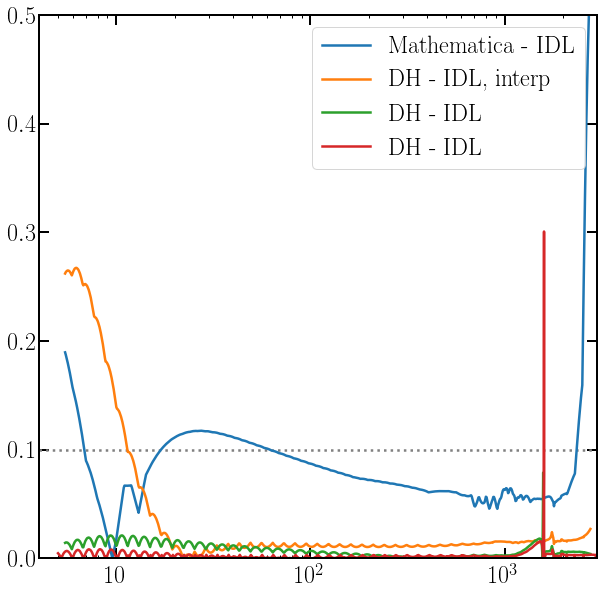

In [357]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ind = 3

def f_math(rs, Einj):
    return f_mathematica(rs,Einj,ind)

def f_idl_interp(rs):
    return interp1d(idl_redshift, f_idl[ind,:])(rs)

# plt.plot(idl_redshift, f_idl[ind,:], label='IDL')
# plt.plot(rs_list, tabulate(rs_list, Einj, f_math)[0], label='Mathematica')
# plt.plot(rs_list, DH_fs[:,ind], label='DH')


plt.axis([4,3e3,0,.5])
ax.axhline(.1, color='gray', linestyle=':')
# ax.axvline(1600, color='k')

plt.plot(rs_list[10:-10], 
         np.abs((f_idl_interp(rs_list[10:-10])-tabulate(rs_list[10:-10], Einj, f_math)[0])/f_idl_interp(rs_list[10:-10]))
         , label='Mathematica - IDL')
plt.plot(rs_list[10:-10], 
         np.abs((f_idl_interp(rs_list[10:-10])-DH_fs[10:-10,ind])/f_idl_interp(rs_list[10:-10]))
         , label='DH - IDL, interp')
plt.plot(rs_list[10:-10], 
         np.abs((f_idl_interp(rs_list[10:-10])-data_phot[6][10:-10,ind])/f_idl_interp(rs_list[10:-10]))
         , label='DH - IDL')
plt.plot(idl_redshift[:6397], 
         np.abs((f_idl[ind,:6397]-data_phot0[6][:,ind])/f_idl[ind,:6397])
         , label='DH - IDL')

plt.legend()

In [353]:
utils.compare_arr([data_phot0[3].rs[:-1], data_phot0[6][:,4]])

[[ 3.00000000e+03  0.00000000e+00]
 [ 2.99700150e+03 -1.26120740e-03]
 [ 2.99400600e+03 -6.87687868e-03]
 [ 2.99101349e+03 -8.94364450e-03]
 [ 2.98802397e+03 -1.01435231e-02]
 [ 2.98503744e+03 -1.08017095e-02]
 [ 2.98205389e+03 -1.10973205e-02]
 [ 2.97907333e+03 -1.11360466e-02]
 [ 2.97609574e+03 -1.09848667e-02]
 [ 2.97312114e+03 -1.06888179e-02]
 [ 2.97014950e+03 -1.02796633e-02]
 [ 2.96718084e+03 -9.78067382e-03]
 [ 2.96421514e+03 -9.20942715e-03]
 [ 2.96125241e+03 -8.57953199e-03]
 [ 2.95829263e+03 -7.90173905e-03]
 [ 2.95533582e+03 -7.18468367e-03]
 [ 2.95238196e+03 -6.43539843e-03]
 [ 2.94943105e+03 -5.65967693e-03]
 [ 2.94648310e+03 -4.86233799e-03]
 [ 2.94353809e+03 -4.04742179e-03]
 [ 2.94059602e+03 -3.21833802e-03]
 [ 2.93765689e+03 -2.37797973e-03]
 [ 2.93472071e+03 -1.52881221e-03]
 [ 2.93178745e+03 -6.72943061e-04]
 [ 2.92885713e+03  1.87821558e-04]
 [ 2.92592974e+03  1.05193157e-03]
 [ 2.92300527e+03  1.91805585e-03]
 [ 2.92008372e+03  2.78505160e-03]
 [ 2.91716510e+03  3

0

### swave, electrons

In [95]:
%autoreload
inj_type='swave'
end_rs = 5
sigmav = 1e-33#1e-26
tau=1e24
f_swave_elec = []
for i,Einj in enumerate(tqdm(10**log10eng[:-1])):
    mDM = Einj + phys.me
    Ecom=2*mDM
    phot_spec_init = Spectrum(photeng,
                             np.zeros_like(photeng),
                             spec_type='N',
                             rs=3000)
    
    indTmp = spectools.get_indx(eleceng,Einj)
    if eleceng[indTmp] >= Einj:
        indTmp -= 1
    
    elec_spec_init = spectools.rebin_N_arr(
        np.array([2*Einj/eleceng[indTmp]]),
        np.array([eleceng[indTmp]]),
        eleceng
    )
#     elec_spec_init = spectools.rebin_N_arr(np.array([2]), 
#                                       np.array([Einj]), 
#                                       eleceng)
    elec_spec_init.rs = 3000
    elec_spec_init.switch_spec_type()
    
    data_elec = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_swave_N, rate_func_swave_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=16, std_soln=True,
        struct_boost=struct_boost,
        reion_switch=False
    )

    f_swave_elec.append(data_elec[5])

rs_list_elec = data_elec[3].rs
f_swave_elec = np.array(f_swave_elec)

pickle.dump(f_swave_elec, open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "wb"))

/home/gridgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [255]:
pickle.dump(f_swave_elec, open("/home/gridgway/Desktop/f_contour_debug/f_swave_elec.p", "wb"))
pickle.dump(f_swave_phot, open("/home/gridgway/Desktop/f_contour_debug/f_swave_phot.p", "wb"))
pickle.dump(f_decay_elec, open("/home/gridgway/Desktop/f_contour_debug/f_decay_elec.p", "wb"))
pickle.dump(f_decay_phot, open("/home/gridgway/Desktop/f_contour_debug/f_decay_phot.p", "wb"))

In [317]:
for i,fs in enumerate(f_decay_elec):
    fs = fs * 10**log10eng[i]/(10**log10eng[i] + phys.me)

In [314]:
f_decay_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_elec.p", "rb"))
f_decay_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_decay_phot.p", "rb"))
f_swave_elec = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_elec.p", "rb"))
f_swave_phot = pickle.load(open("/home/gridgway/Dropbox (MIT)/Photon Deposition/f_swave_phot.p", "rb"))

# For comparison

-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

-Why don't we go above 5 TeV?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation


- Structure Formation
    - swave
    - on/off switch
    - optimistic/conservative
    - (just a change to the annihilation rate)
    
- minimum lifetime (do this first, structure independent)/maximum cross-section
    - residual plot of with back-reaction vs. not back-react (temperature), contour plots
    - for each mass pick the minimum tau or maximum cross-section and compare the std_switch on or off
    
- New 21cm sensitivity
    - Hongwan's plots, but now with DarkHistory

# NEED TO CHECK

In [393]:
import darkhistory.low_energy.lowE_deposition as lowE_dep
%autoreload

time=-2
tau=1e23
rs_tmp = a1[3][time].rs
print(sum(lowE_dep.compute_fs(
    a1[4][time], 
    a1[3][time], 
    np.array([1-xe_std(rs_tmp),0,0]), 
    rate_func_eng(rs_tmp), 
    .002/phys.hubble(rs_tmp), 
    0
))*rate_func_eng(rs_tmp)*.002/phys.hubble(rs_tmp)/phys.nB/rs_tmp**3)
print(a1[4][time].toteng()+a1[3][time].toteng())

0.0054045385439492315
0.005405394701886692
